# Law of Large Numbers and Central Limit Theorem for t-Distribution

This notebook demonstrates the **Law of Large Numbers (LLN)** and the **Central Limit Theorem (CLT)** for the t-distribution with different degrees of freedom (ν).

## Overview

- **Law of Large Numbers (LLN)**: As the sample size increases, the sample mean converges to the population mean (which is 0 for the t-distribution).
- **Central Limit Theorem (CLT)**: As the sample size increases, the distribution of sample means approaches a normal distribution, regardless of the original distribution (under certain conditions).

For the t-distribution:
- The population mean is **0** (for all ν > 0)
- The population variance is **ν/(ν-2)** (for ν > 2)
- For ν ≤ 2, the variance is infinite, which affects the applicability of CLT


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Try to import seaborn, but continue without it if not available
try:
    import seaborn as sns
    sns.set_palette("husl")
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        print("Using default matplotlib style")

# Set random seed for reproducibility
np.random.seed(42)


## Simulation Parameters

We'll simulate:
- **M = 500** independent samples
- Each sample has **N = 10,000** draws
- We'll compute sample means for different sample sizes: **n = 5, 10, 100, 500, 1000, 10000**
- We'll test different degrees of freedom: **ν = 100, 10, 5, 2, 1, 0.5**


In [2]:
# Simulation parameters
M = 500  # Number of independent samples
N = 10000  # Length of each sample
n_values = [5, 10, 100, 500, 1000, 10000]  # Sample sizes for computing means
nu_values = [100, 10, 5, 2, 1, 0.5]  # Degrees of freedom to test

print(f"Simulation setup:")
print(f"  M = {M} independent samples")
print(f"  N = {N} draws per sample")
print(f"  Sample sizes n = {n_values}")
print(f"  Degrees of freedom ν = {nu_values}")


Simulation setup:
  M = 500 independent samples
  N = 10000 draws per sample
  Sample sizes n = [5, 10, 100, 500, 1000, 10000]
  Degrees of freedom ν = [100, 10, 5, 2, 1, 0.5]


## Helper Function for Simulation

This function performs the simulation for a given value of ν:


In [3]:
def simulate_t_distribution(nu, M, N, n_values):
    """
    Simulate t-distribution and compute sample means.
    
    Parameters:
    -----------
    nu : float
        Degrees of freedom for t-distribution
    M : int
        Number of independent samples
    N : int
        Length of each sample
    n_values : list
        Sample sizes for computing means
    
    Returns:
    --------
    sample_means : dict
        Dictionary with n as keys and array of M sample means as values
    stats_table : pandas.DataFrame
        Table with mean, std, and variance of sample means for each n
    """
    # Draw M i.i.d. random samples of length N from t_nu distribution
    samples = stats.t.rvs(df=nu, size=(M, N))
    
    # For each sample, compute sample means for different n values
    sample_means = {}
    
    for n in n_values:
        if n > N:
            continue  # Skip if n exceeds sample length
        # Compute sample mean for first n observations for each of M samples
        means = np.mean(samples[:, :n], axis=1)
        sample_means[n] = means
    
    # Compute statistics for each n
    stats_data = []
    for n in sorted(sample_means.keys()):
        means = sample_means[n]
        stats_data.append({
            'n': n,
            'Mean': np.mean(means),
            'Std Dev': np.std(means, ddof=1),
            'Variance': np.var(means, ddof=1)
        })
    
    stats_table = pd.DataFrame(stats_data)
    
    return sample_means, stats_table


## Part 1: Simulation for ν = 100

Starting with ν = 100, which is close to a normal distribution (t-distribution approaches normal as ν → ∞).


In [4]:
nu = 100
sample_means_100, stats_table_100 = simulate_t_distribution(nu, M, N, n_values)

print(f"Statistics for ν = {nu}")
print("=" * 60)
print(stats_table_100.to_string(index=False))
print("\nTheoretical values:")
print(f"  Population mean: 0.0")
if nu > 2:
    theoretical_var = nu / (nu - 2)
    theoretical_std = np.sqrt(theoretical_var)
    print(f"  Population variance: {theoretical_var:.6f}")
    print(f"  Population std dev: {theoretical_std:.6f}")
    print(f"  Expected std of sample mean (n→∞): {theoretical_std/np.sqrt(N):.6f}")
else:
    print(f"  Population variance: ∞ (undefined for ν ≤ 2)")


Statistics for ν = 100
    n      Mean  Std Dev  Variance
    5  0.004398 0.450126  0.202613
   10 -0.005175 0.308421  0.095123
  100  0.004588 0.091835  0.008434
  500  0.000040 0.046742  0.002185
 1000 -0.000766 0.033361  0.001113
10000 -0.000103 0.010247  0.000105

Theoretical values:
  Population mean: 0.0
  Population variance: 1.020408
  Population std dev: 1.010153
  Expected std of sample mean (n→∞): 0.010102


### Distribution of Sample Means for ν = 100

Plotting the distributions of the M sample means for different values of n:


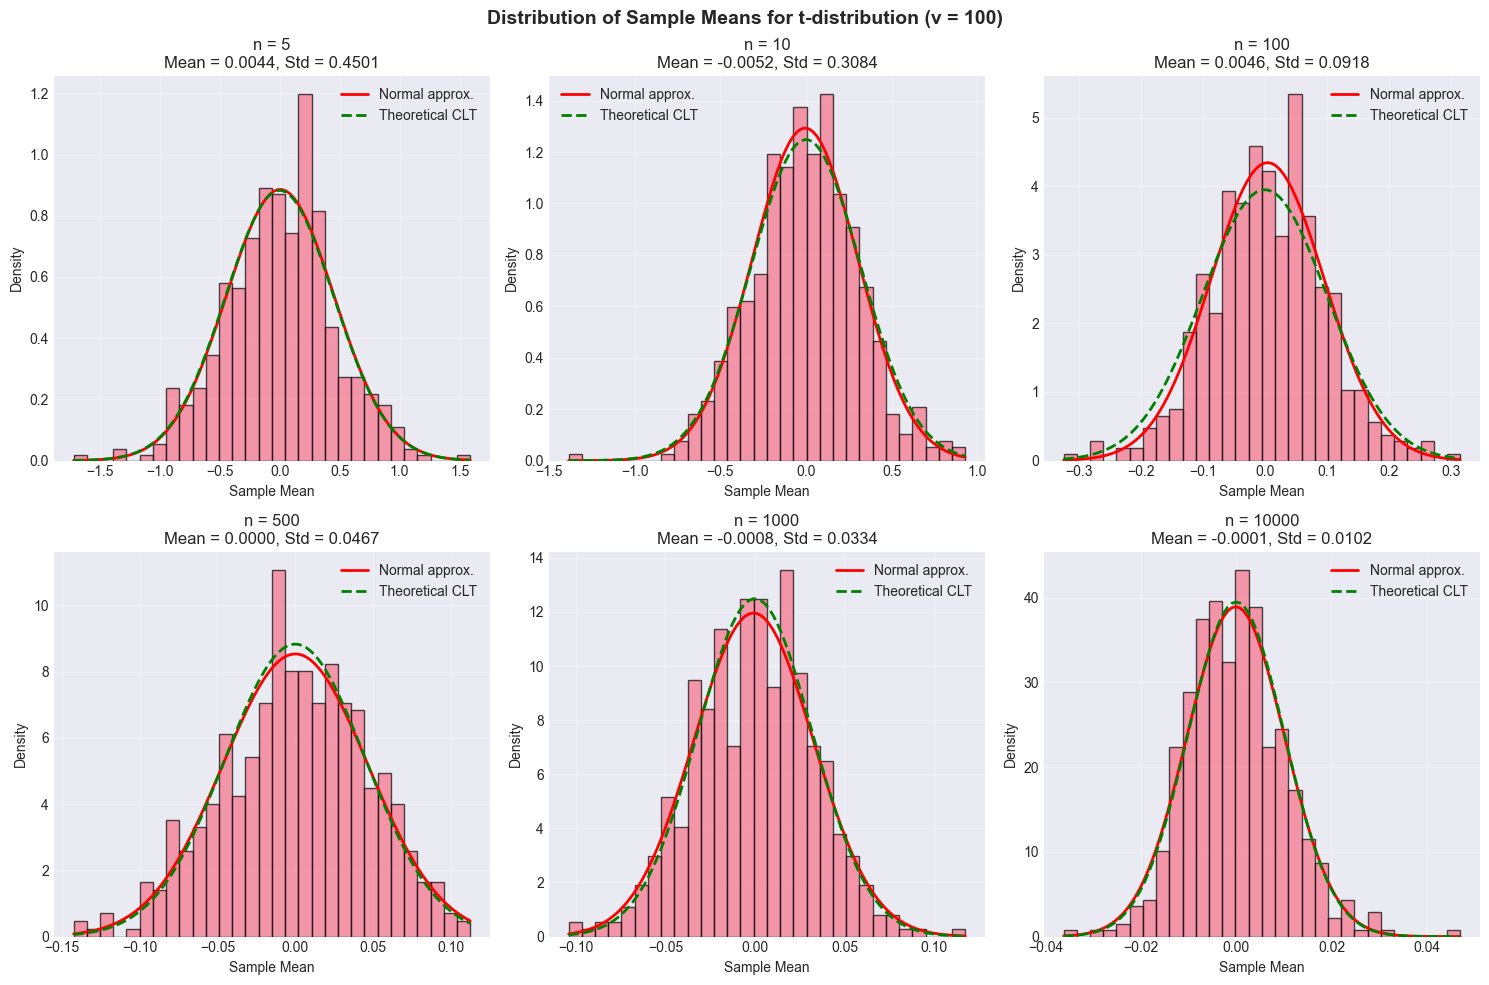

In [5]:
def plot_sample_means(sample_means, nu, title_suffix=""):
    """Plot distributions of sample means for different n values."""
    n_sorted = sorted([n for n in sample_means.keys() if n <= N])
    n_plots = len(n_sorted)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, n in enumerate(n_sorted):
        means = sample_means[n]
        ax = axes[idx]
        
        # Histogram
        ax.hist(means, bins=30, density=True, alpha=0.7, edgecolor='black')
        
        # Overlay normal distribution (CLT prediction)
        mean_empirical = np.mean(means)
        std_empirical = np.std(means, ddof=1)
        x = np.linspace(means.min(), means.max(), 100)
        y_normal = stats.norm.pdf(x, loc=mean_empirical, scale=std_empirical)
        ax.plot(x, y_normal, 'r-', linewidth=2, label='Normal approx.')
        
        # Theoretical normal if variance exists
        if nu > 2:
            theoretical_var = nu / (nu - 2)
            theoretical_std_mean = np.sqrt(theoretical_var / n)
            y_theoretical = stats.norm.pdf(x, loc=0, scale=theoretical_std_mean)
            ax.plot(x, y_theoretical, 'g--', linewidth=2, label='Theoretical CLT')
        
        ax.set_title(f'n = {n}\nMean = {mean_empirical:.4f}, Std = {std_empirical:.4f}')
        ax.set_xlabel('Sample Mean')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Distribution of Sample Means for t-distribution (ν = {nu}){title_suffix}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_sample_means(sample_means_100, nu=100)


### Interpretation for ν = 100

**Law of Large Numbers (LLN):**
- As n increases, the sample means should converge to the population mean (0).
- We can see from the table that the mean of sample means gets closer to 0 as n increases.
- The standard deviation of sample means decreases as n increases, showing convergence.

**Central Limit Theorem (CLT):**
- As n increases, the distribution of sample means should approach a normal distribution.
- For ν = 100, the t-distribution is very close to normal, so CLT applies well.
- The histograms show that as n increases, the distribution becomes more bell-shaped and centered around 0.
- The red curve (empirical normal) and green curve (theoretical CLT) should match well for large n.


## Part 2: Simulation for Different Values of ν

Now we'll repeat the simulation for ν = 10, 5, 2, 1, 0.5 to see how the degrees of freedom affect the limiting behavior.


In [6]:
# Store results for all nu values
all_results = {}

for nu in nu_values:
    print(f"\n{'='*60}")
    print(f"Simulating for ν = {nu}")
    print(f"{'='*60}")
    
    sample_means, stats_table = simulate_t_distribution(nu, M, N, n_values)
    all_results[nu] = {
        'sample_means': sample_means,
        'stats_table': stats_table
    }
    
    print(f"\nStatistics Table for ν = {nu}:")
    print(stats_table.to_string(index=False))
    
    if nu > 2:
        theoretical_var = nu / (nu - 2)
        print(f"\nTheoretical population variance: {theoretical_var:.6f}")
    else:
        print(f"\nTheoretical population variance: ∞ (undefined for ν ≤ 2)")



Simulating for ν = 100

Statistics Table for ν = 100:
    n      Mean  Std Dev  Variance
    5 -0.049475 0.460465  0.212028
   10 -0.004886 0.337967  0.114222
  100  0.000441 0.103537  0.010720
  500  0.000901 0.046025  0.002118
 1000 -0.000367 0.030867  0.000953
10000 -0.000666 0.009353  0.000087

Theoretical population variance: 1.020408

Simulating for ν = 10

Statistics Table for ν = 10:
    n      Mean  Std Dev  Variance
    5 -0.033258 0.514712  0.264928
   10 -0.010795 0.360801  0.130177
  100  0.002465 0.111255  0.012378
  500  0.000653 0.050018  0.002502
 1000  0.002436 0.035026  0.001227
10000  0.000642 0.011407  0.000130

Theoretical population variance: 1.250000

Simulating for ν = 5

Statistics Table for ν = 5:
    n      Mean  Std Dev  Variance
    5 -0.043866 0.585444  0.342745
   10 -0.012779 0.396230  0.156998
  100 -0.005605 0.132651  0.017596
  500  0.002001 0.060511  0.003662
 1000  0.002332 0.042843  0.001836
10000 -0.000855 0.013314  0.000177

Theoretical populat

### Visualizing Distributions for All ν Values

Let's plot the distributions for each ν value:


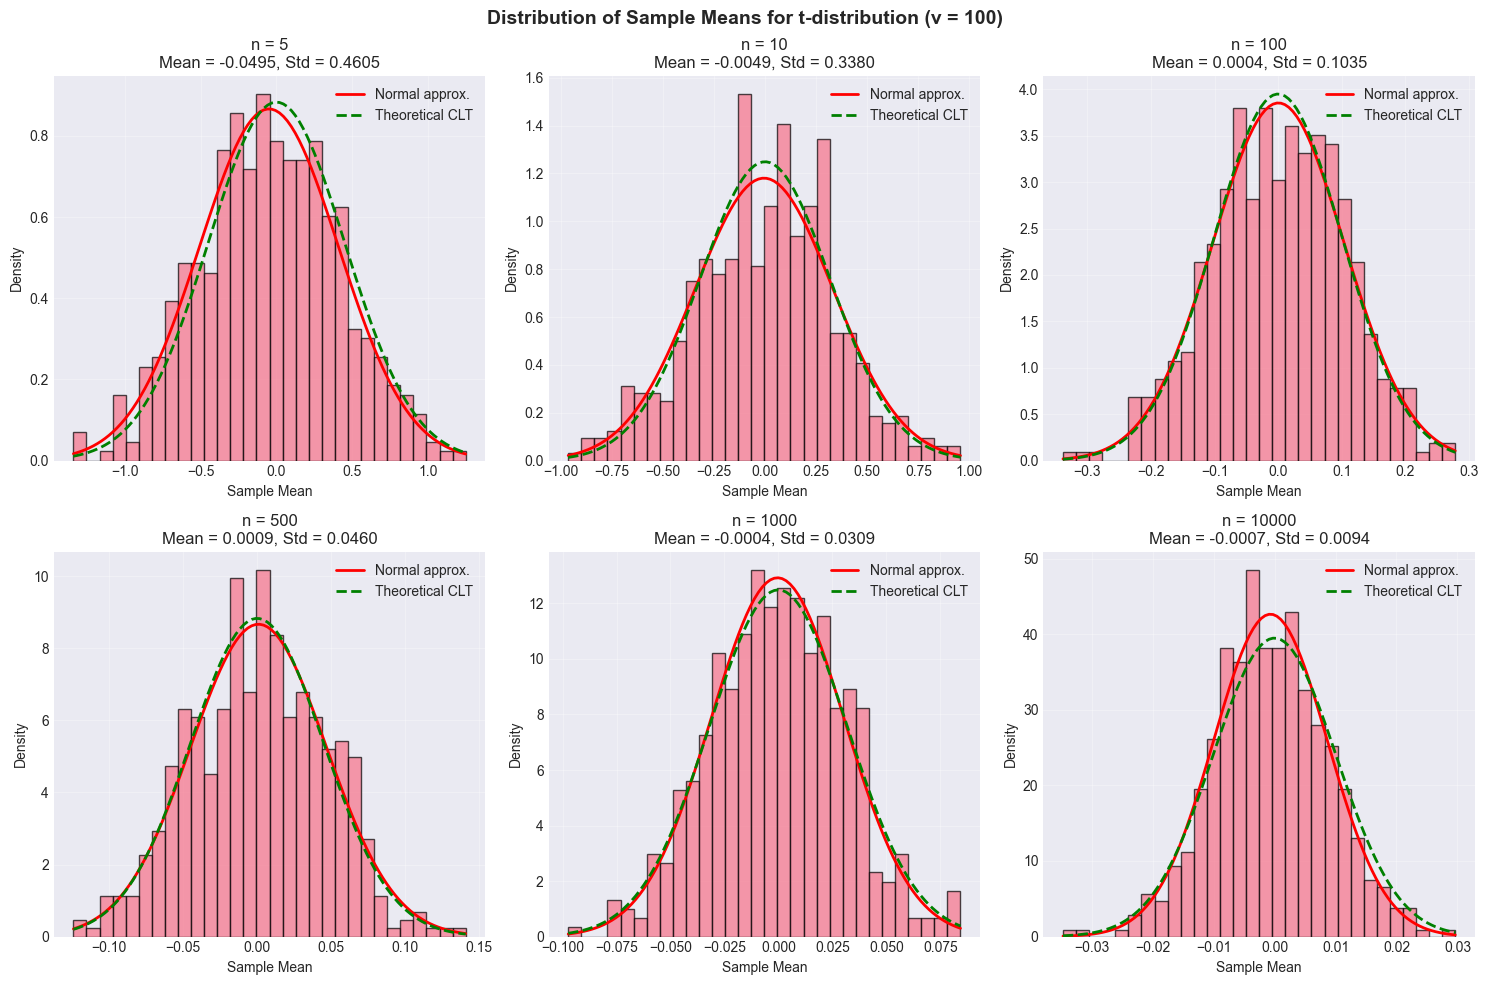

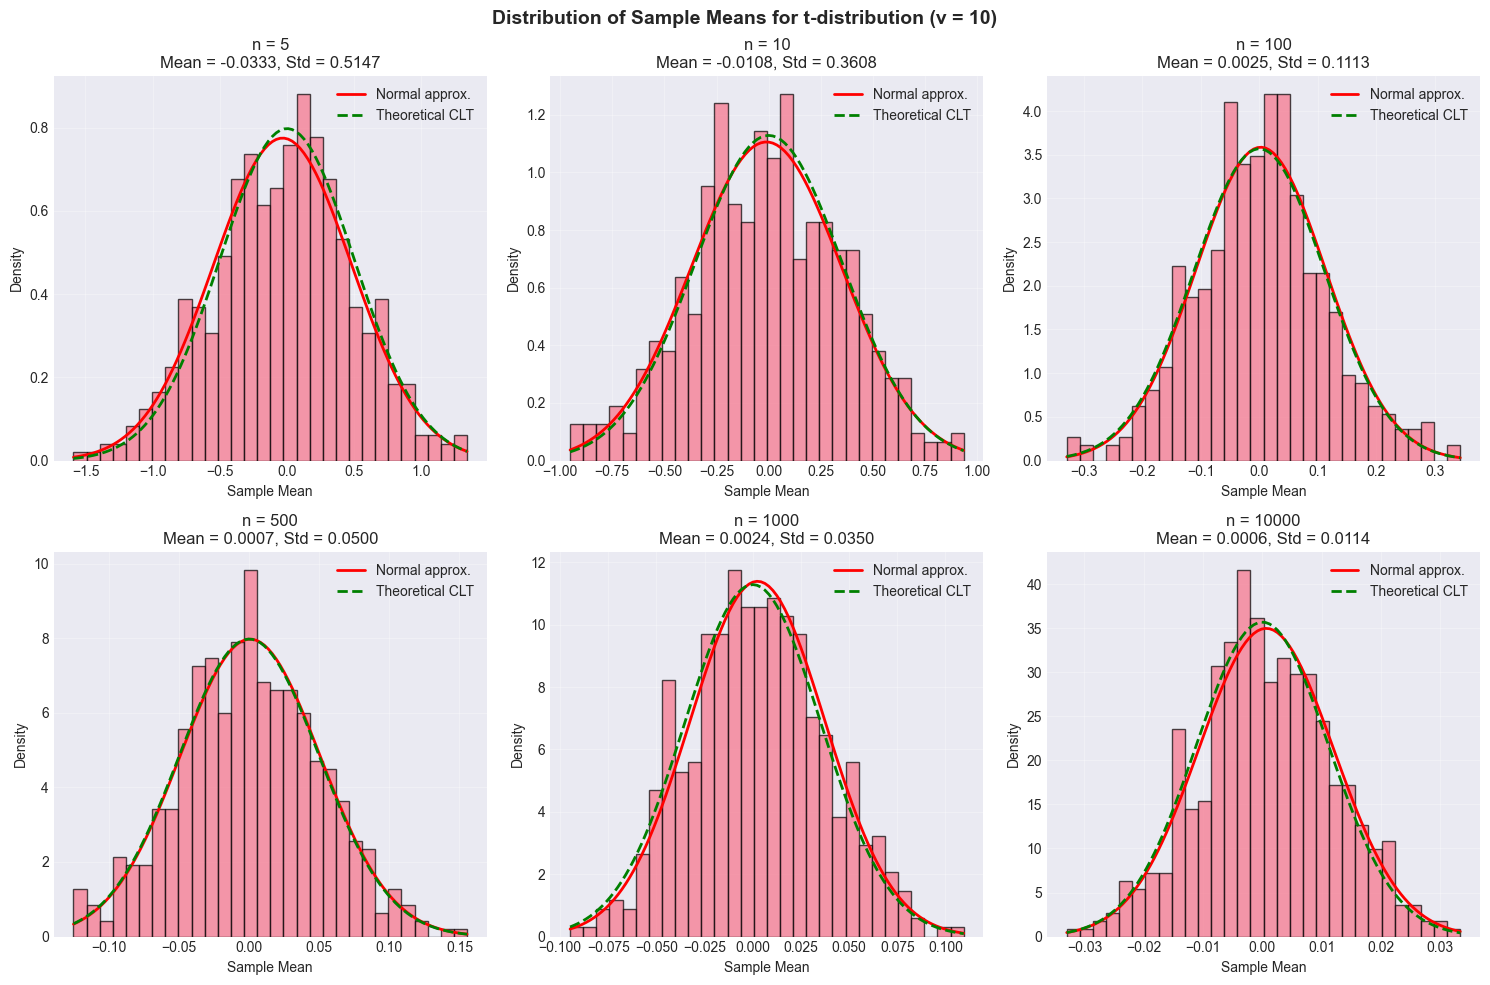

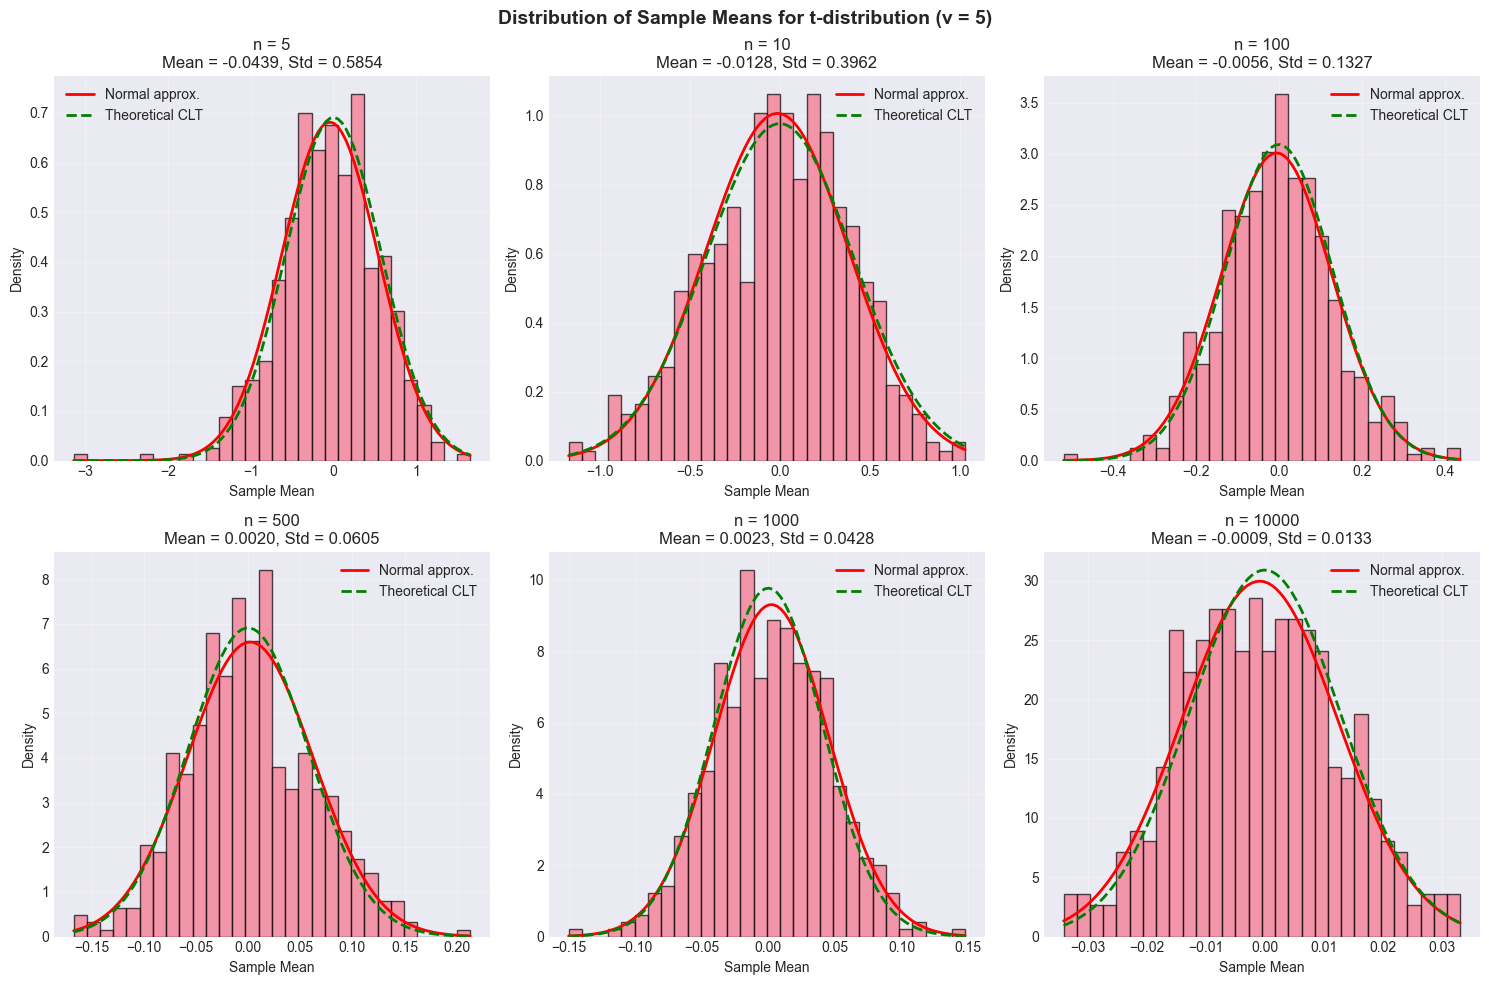

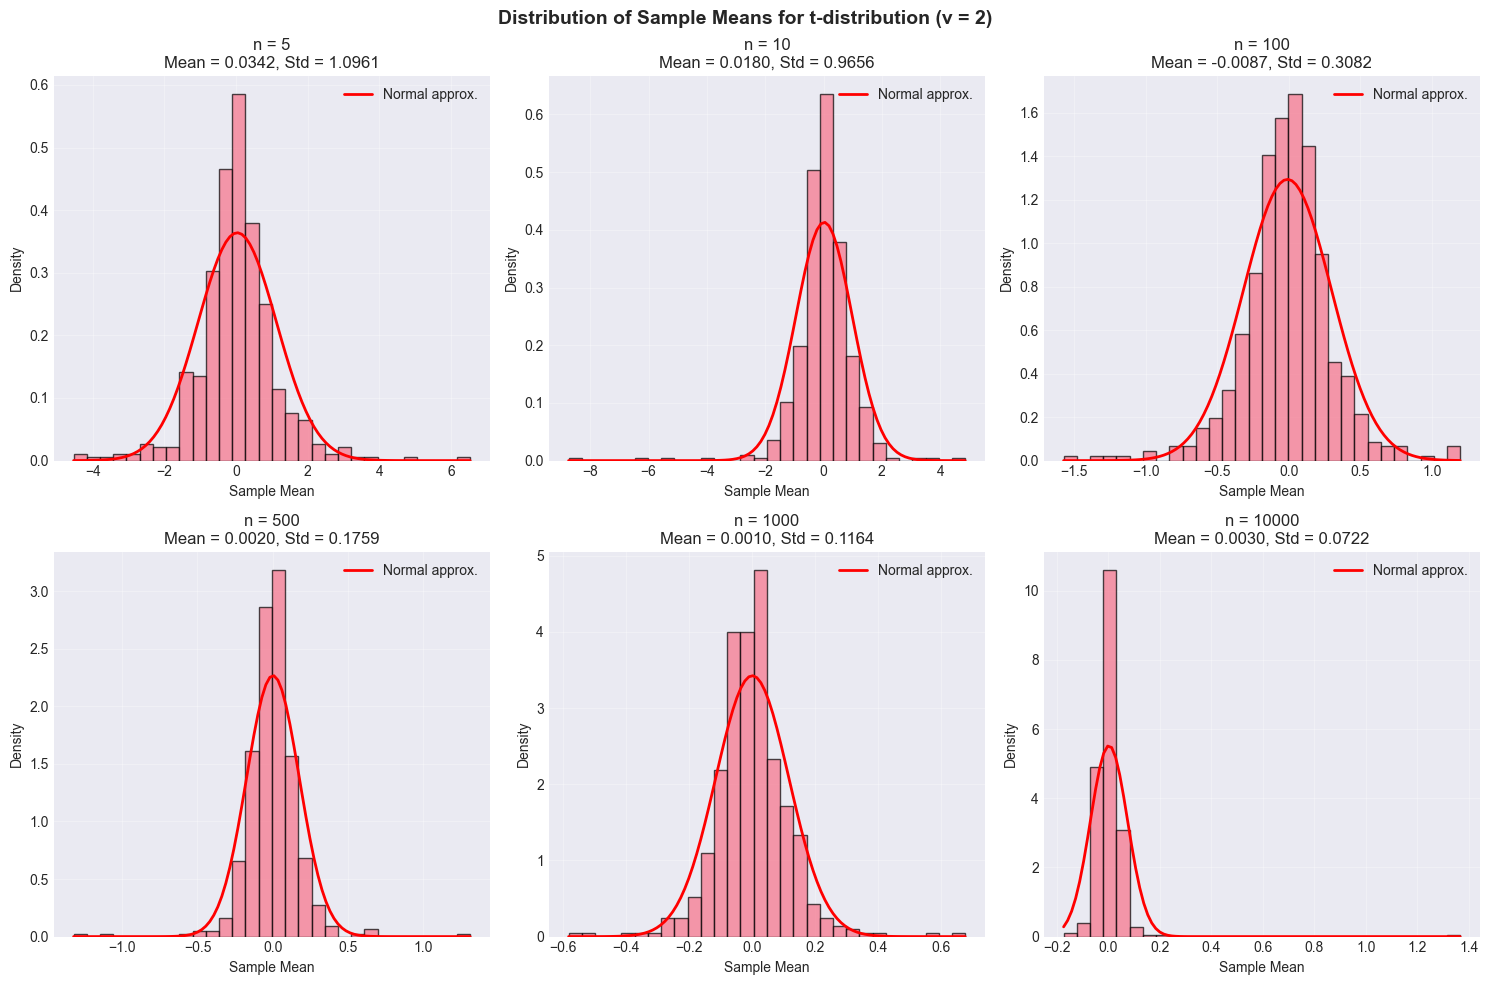

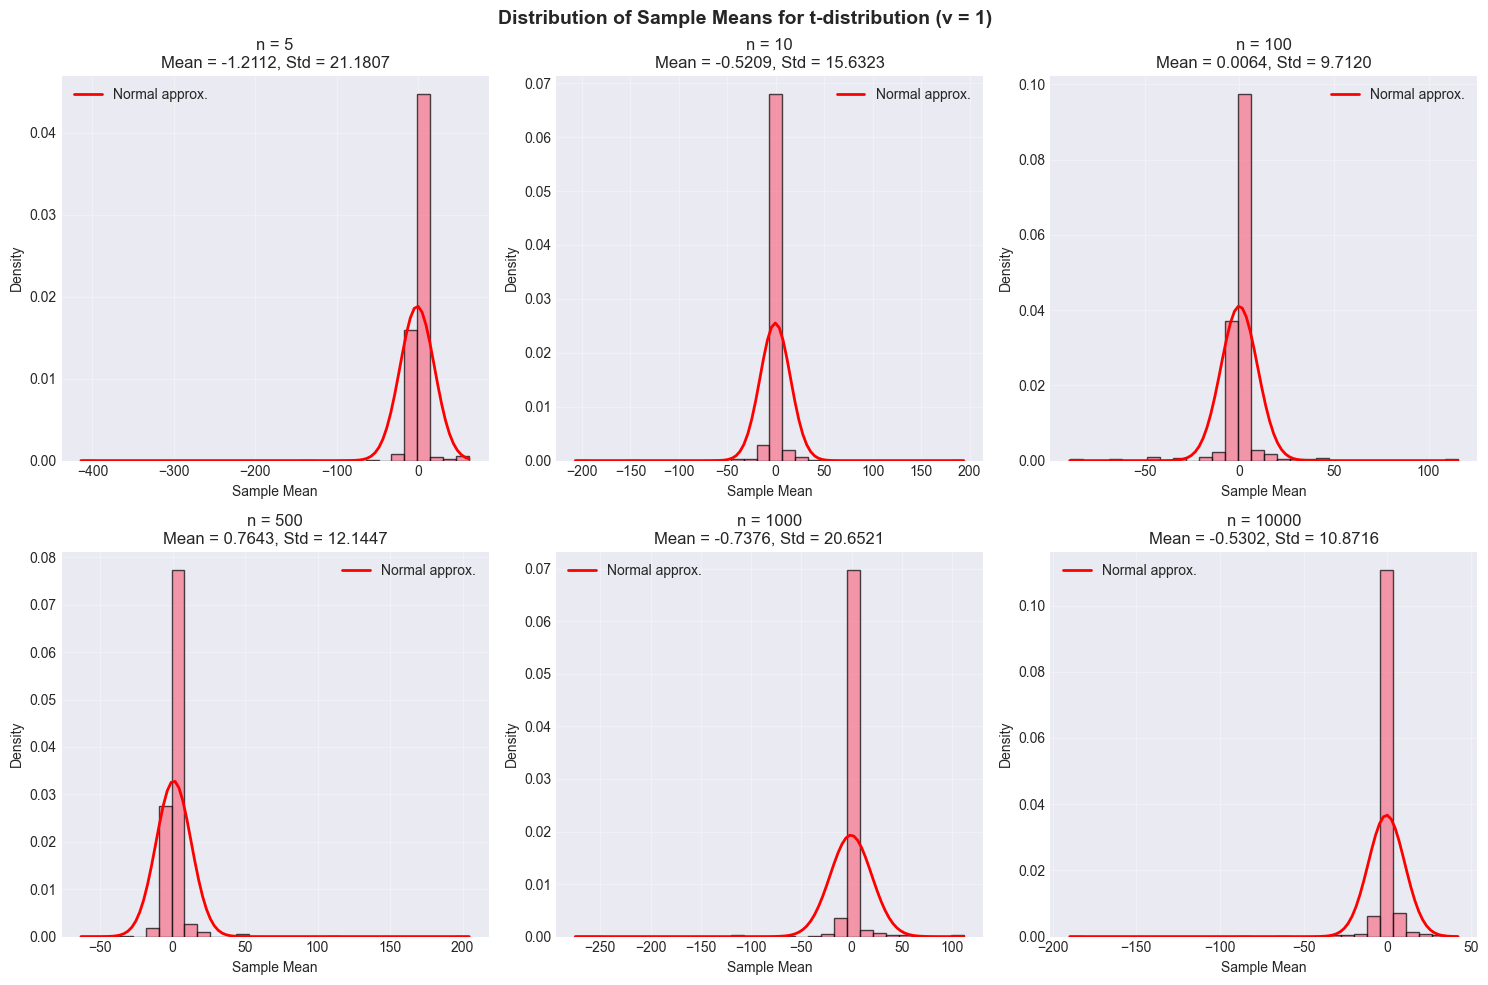

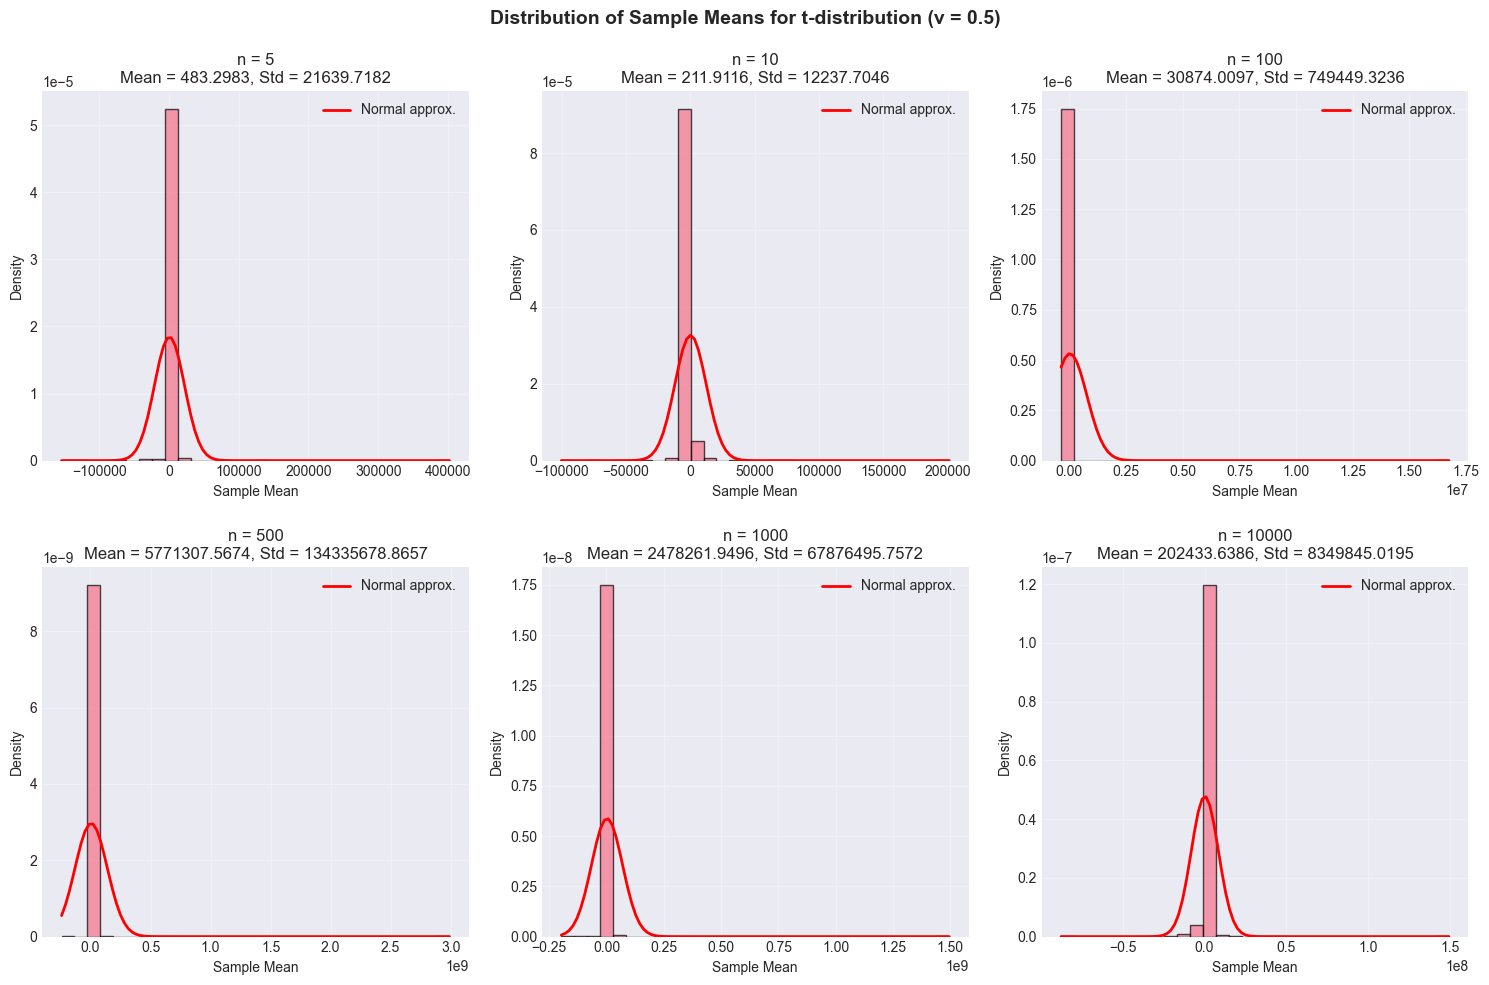

In [7]:
for nu in nu_values:
    plot_sample_means(all_results[nu]['sample_means'], nu)


### Comparison: Standard Deviation of Sample Means Across ν

Let's visualize how the standard deviation of sample means changes with n for different ν values:


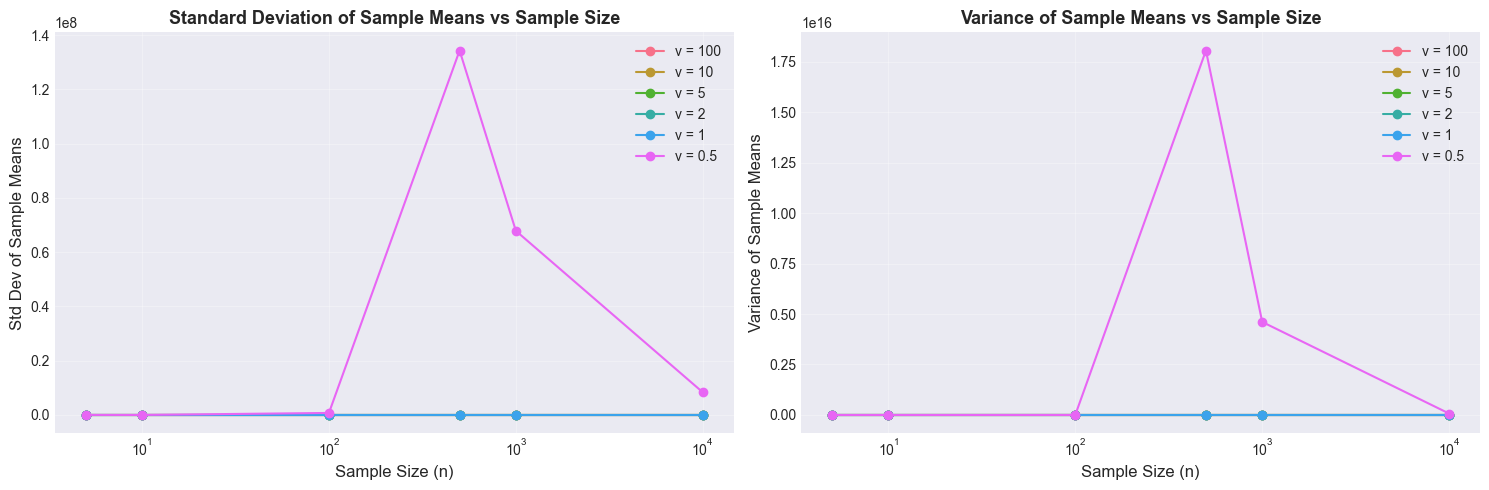

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Standard deviation vs n
ax1 = axes[0]
for nu in nu_values:
    stats_table = all_results[nu]['stats_table']
    ax1.plot(stats_table['n'], stats_table['Std Dev'], marker='o', label=f'ν = {nu}')

ax1.set_xlabel('Sample Size (n)', fontsize=12)
ax1.set_ylabel('Std Dev of Sample Means', fontsize=12)
ax1.set_title('Standard Deviation of Sample Means vs Sample Size', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Variance vs n
ax2 = axes[1]
for nu in nu_values:
    stats_table = all_results[nu]['stats_table']
    ax2.plot(stats_table['n'], stats_table['Variance'], marker='o', label=f'ν = {nu}')

ax2.set_xlabel('Sample Size (n)', fontsize=12)
ax2.set_ylabel('Variance of Sample Means', fontsize=12)
ax2.set_title('Variance of Sample Means vs Sample Size', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Comparison: Mean of Sample Means Across ν

Let's check how well the sample means converge to 0 (the population mean):


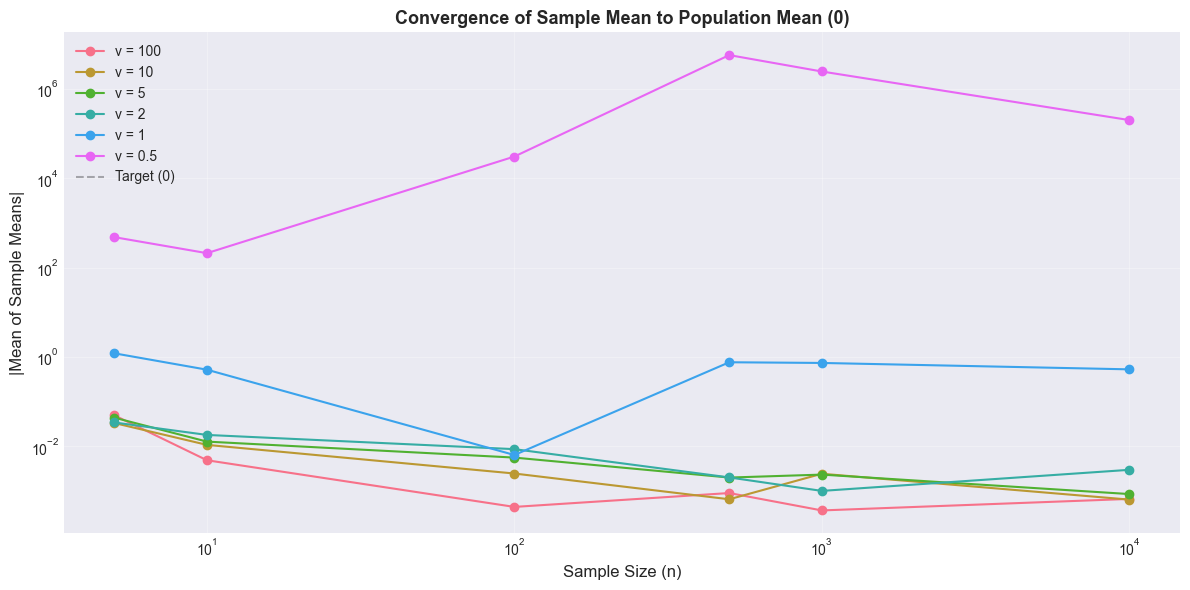

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for nu in nu_values:
    stats_table = all_results[nu]['stats_table']
    ax.plot(stats_table['n'], np.abs(stats_table['Mean']), marker='o', label=f'ν = {nu}')

ax.set_xlabel('Sample Size (n)', fontsize=12)
ax.set_ylabel('|Mean of Sample Means|', fontsize=12)
ax.set_title('Convergence of Sample Mean to Population Mean (0)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Target (0)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Detailed Comparison Table

Let's create a comprehensive table comparing all results:


In [10]:
# Create a comprehensive comparison table
comparison_data = []

for nu in nu_values:
    stats_table = all_results[nu]['stats_table']
    for _, row in stats_table.iterrows():
        comparison_data.append({
            'ν': nu,
            'n': row['n'],
            'Mean': row['Mean'],
            'Std Dev': row['Std Dev'],
            'Variance': row['Variance']
        })

comparison_df = pd.DataFrame(comparison_data)

# Pivot tables for better visualization
print("=" * 80)
print("MEAN OF SAMPLE MEANS")
print("=" * 80)
mean_pivot = comparison_df.pivot(index='n', columns='ν', values='Mean')
print(mean_pivot.round(6))

print("\n" + "=" * 80)
print("STANDARD DEVIATION OF SAMPLE MEANS")
print("=" * 80)
std_pivot = comparison_df.pivot(index='n', columns='ν', values='Std Dev')
print(std_pivot.round(6))

print("\n" + "=" * 80)
print("VARIANCE OF SAMPLE MEANS")
print("=" * 80)
var_pivot = comparison_df.pivot(index='n', columns='ν', values='Variance')
print(var_pivot.round(6))


MEAN OF SAMPLE MEANS
ν               0.5       1.0       2.0       5.0       10.0      100.0
n                                                                      
5.0      4.832983e+02 -1.211224  0.034232 -0.043866 -0.033258 -0.049475
10.0     2.119116e+02 -0.520864  0.018034 -0.012779 -0.010795 -0.004886
100.0    3.087401e+04  0.006408 -0.008657 -0.005605  0.002465  0.000441
500.0    5.771308e+06  0.764330  0.002015  0.002001  0.000653  0.000901
1000.0   2.478262e+06 -0.737569  0.001006  0.002332  0.002436 -0.000367
10000.0  2.024336e+05 -0.530206  0.002982 -0.000855  0.000642 -0.000666

STANDARD DEVIATION OF SAMPLE MEANS
ν               0.5        1.0       2.0       5.0       10.0      100.0
n                                                                       
5.0      2.163972e+04  21.180652  1.096091  0.585444  0.514712  0.460465
10.0     1.223770e+04  15.632325  0.965608  0.396230  0.360801  0.337967
100.0    7.494493e+05   9.712031  0.308226  0.132651  0.111255  0.103537
50

## Analysis: How ν Affects the Limiting Behavior

### Key Observations

1. **Law of Large Numbers (LLN):**
   - For all values of ν, as n increases, the sample means converge to the population mean (0).
   - This convergence is observed regardless of the value of ν.
   - The rate of convergence may vary, but the limit is always 0.

2. **Central Limit Theorem (CLT):**
   - **For ν > 2**: The population variance exists (ν/(ν-2)), so CLT applies.
     - The standard deviation of sample means should decrease as 1/√n.
     - The distribution of sample means approaches a normal distribution.
     - For larger ν (e.g., ν = 100), CLT works very well even for moderate n.
     - For smaller ν (e.g., ν = 10, 5), CLT still applies but convergence is slower.
   
   - **For ν ≤ 2**: The population variance is infinite.
     - CLT in its standard form does **not** apply (requires finite variance).
     - The standard deviation of sample means does not follow the 1/√n scaling.
     - For ν = 2, variance is infinite, so sample means have heavier tails.
     - For ν = 1 (Cauchy distribution), the sample mean itself doesn't converge to a normal distribution in the traditional sense.
     - For ν < 1, the situation is even more extreme.

3. **Effect of ν on Convergence:**
   - **Larger ν (ν = 100)**: 
     - Very close to normal distribution
     - Fast convergence to CLT
     - Standard deviation decreases smoothly as 1/√n
   
   - **Medium ν (ν = 10, 5)**:
     - Heavier tails than normal
     - CLT still applies but slower convergence
     - More variability in sample means for small n
   
   - **Small ν (ν = 2)**:
     - Infinite variance
     - CLT doesn't apply in standard form
     - Sample means have very heavy tails
   
   - **Very small ν (ν = 1, 0.5)**:
     - No finite variance
     - Sample mean distribution doesn't converge to normal
     - Extreme outliers are more common
     - The distribution of sample means remains heavy-tailed even for large n


### Visual Comparison: Distribution Shapes for Large n (n=10000)

Let's compare the distributions of sample means for n=10000 across different ν values:


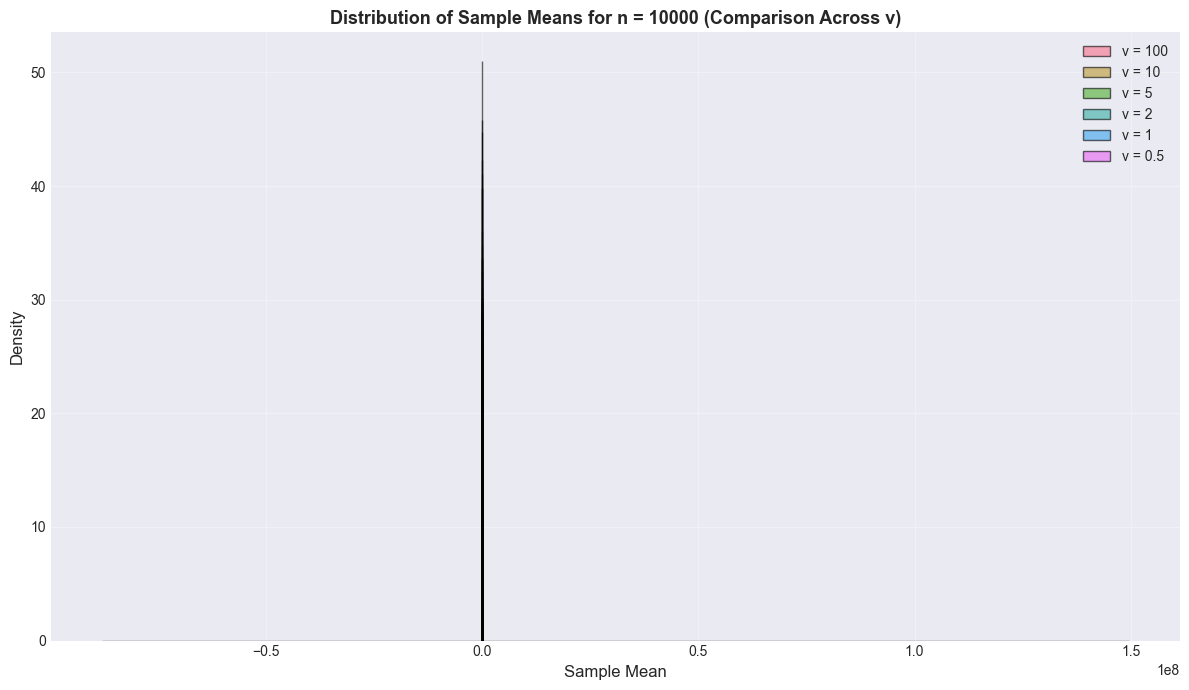

In [11]:
n_compare = 10000
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for nu in nu_values:
    if n_compare in all_results[nu]['sample_means']:
        means = all_results[nu]['sample_means'][n_compare]
        ax.hist(means, bins=40, alpha=0.6, density=True, label=f'ν = {nu}', edgecolor='black')

ax.set_xlabel('Sample Mean', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Distribution of Sample Means for n = {n_compare} (Comparison Across ν)', 
             fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Theoretical vs Empirical Standard Deviation

For ν > 2, we can compare the empirical standard deviation with the theoretical prediction from CLT:


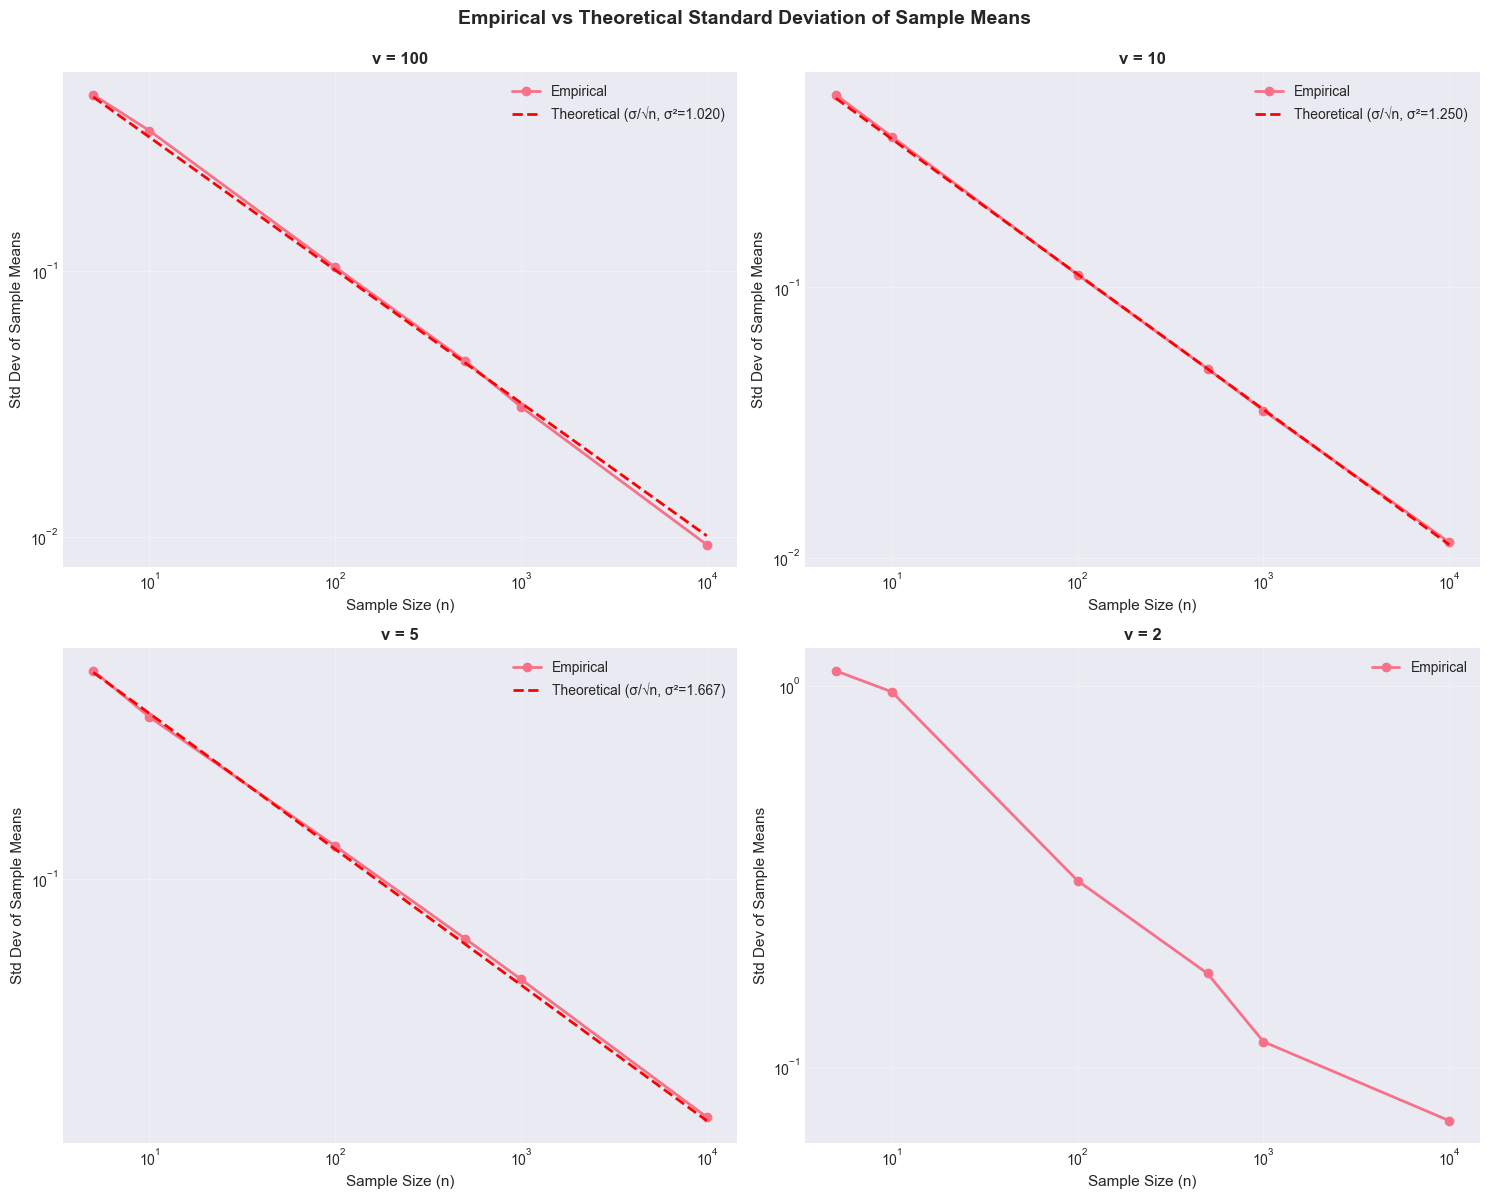

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

nu_to_plot = [100, 10, 5, 2]
for idx, nu in enumerate(nu_to_plot):
    ax = axes[idx]
    stats_table = all_results[nu]['stats_table']
    
    # Empirical
    ax.plot(stats_table['n'], stats_table['Std Dev'], 'o-', label='Empirical', linewidth=2)
    
    # Theoretical (if variance exists)
    if nu > 2:
        theoretical_var = nu / (nu - 2)
        theoretical_std = np.sqrt(theoretical_var)
        theoretical_std_means = theoretical_std / np.sqrt(stats_table['n'])
        ax.plot(stats_table['n'], theoretical_std_means, 'r--', 
                label=f'Theoretical (σ/√n, σ²={theoretical_var:.3f})', linewidth=2)
    
    ax.set_xlabel('Sample Size (n)', fontsize=11)
    ax.set_ylabel('Std Dev of Sample Means', fontsize=11)
    ax.set_title(f'ν = {nu}', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Empirical vs Theoretical Standard Deviation of Sample Means', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Summary and Conclusions

### Law of Large Numbers (LLN)
- **Applies to all ν > 0**: The sample mean converges to the population mean (0) as n → ∞.
- This is observed in our simulations: as n increases, the mean of sample means approaches 0.
- LLN does not require finite variance, so it works even for ν ≤ 2.

### Central Limit Theorem (CLT)
- **Requires finite variance**: CLT applies when ν > 2.
- For ν > 2:
  - The distribution of sample means converges to N(0, σ²/n) where σ² = ν/(ν-2).
  - The standard deviation of sample means decreases as 1/√n.
  - Convergence is faster for larger ν (closer to normal).
- For ν ≤ 2:
  - Population variance is infinite.
  - Standard CLT does not apply.
  - Sample means have heavy-tailed distributions.
  - For ν = 1 (Cauchy), the sample mean has the same distribution as a single observation!

### Effect of ν on Limiting Behavior

1. **ν = 100**: 
   - Very close to normal, fast CLT convergence
   - Standard deviation follows 1/√n scaling closely

2. **ν = 10, 5**: 
   - Heavier tails, slower CLT convergence
   - Still follows 1/√n scaling (with finite variance)

3. **ν = 2**: 
   - Infinite variance, CLT doesn't apply
   - Standard deviation doesn't follow 1/√n scaling

4. **ν = 1, 0.5**: 
   - No finite variance
   - Sample mean distribution doesn't converge to normal
   - Extreme values are common even for large n

### Key Takeaway
The degrees of freedom ν critically determines whether CLT applies. While LLN holds for all ν > 0, CLT requires ν > 2 (finite variance). As ν decreases, the t-distribution becomes more heavy-tailed, making the convergence to normality slower (when it exists) or impossible (when variance is infinite).
